In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocess

In the preprocessing of the raw dataset, the variables are transformed to the real input of each model.

In [118]:
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

import preprocess.X as X_pre
import preprocess.y as y_pre

from utils.constants import RAW_DIR, STAGE_DIR, ANALYSIS_DIR
from utils.dataload import load_data
from utils.display import cdisplay
from utils.functions import inspect_nulls
from utils.plots import plot_resampling
from utils.transformers import (NameTransformer, AssignTransformer,
    AggregateTransformer, MinMaxScalerTransformer)

In [67]:
train_df = load_data(RAW_DIR / 'train.csv', load_func=pd.read_csv)
test_df = load_data(RAW_DIR / 'test.csv', load_func=pd.read_csv)

## Transformers - `X`
Each of the following transformers has the objective to processed the dataframe to turn it suitable for training machine learning models. The steps in the pipeline are:
* `NameTransformer`: Transforms column names into readable variable names
* `AssignTransformer`: Impute values for NaN observations in `monthly_rent`, `number_tablet`, `behind_school_years`, `education_years_mean_18+` and `education_years_mean_18+_sqd`
* `AggregationTransformer`: Brings all data to household level
* `MinMaxScaler`: Transform data to a common scale

In [68]:
name_transformer = NameTransformer(X_pre.NAMES_MAP, X_pre.KEEP_FEATURES)

assign_transformer = AssignTransformer(X_pre.ASSIGN_MAP)

aggregate_transformer = AggregateTransformer(
    X_pre.AGGREGATE_MAP, X_pre.INDEX_KEY, keep=True,
    exclude=['rubbish_disposal_throw_river_creek_sea'])

min_max_scaler = MinMaxScalerTransformer()

In [69]:
X_pipeline = make_pipeline(
    name_transformer,
    assign_transformer,
    aggregate_transformer,
    min_max_scaler
)

### NameTransformer

In [70]:
train_named_df = name_transformer.transform(train_df)
test_named_df = name_transformer.transform(test_df)

In [71]:
print(f'''
Train dataset:
    * {train_named_df.shape=}
    * {train_df.shape=}
''')


Train dataset:
    * train_named_df.shape=(9557, 138)
    * train_df.shape=(9557, 143)



In [72]:
inspect_nulls(train_named_df)

monthly_rent                    6860
number_tablet                   7342
behind_school_years             7928
education_years_mean_18+           5
education_years_mean_18+_sqd       5
dtype: int64

In [73]:
inspect_nulls(test_named_df)

monthly_rent                    17403
number_tablet                   18126
behind_school_years             19653
education_years_mean_18+           31
education_years_mean_18+_sqd       31
dtype: int64

### AssignTransformer

In [74]:
train_assigned_df = assign_transformer.transform(train_named_df)
test_assigned_df = assign_transformer.transform(test_named_df)

In [75]:
inspect_nulls(train_assigned_df)

Series([], dtype: int64)

In [76]:
inspect_nulls(test_assigned_df)

Series([], dtype: int64)

### AggregateTransformer

In [77]:
train_aggregated_df = aggregate_transformer.transform(train_assigned_df)
test_aggregated_df = aggregate_transformer.transform(test_assigned_df)

In [78]:
train_assigned_df.shape

(9557, 138)

In [79]:
train_aggregated_df.shape

(2988, 137)

In [80]:
cdisplay(train_aggregated_df)

,is_disable_sum,kinship_household_head_sum,kinship_partner_sum,kinship_children_sum,kinship_stepchildren_sum,kinship_children_in_low_sum,kinship_grandchildren_sum,kinship_parent_sum,kinship_parent_in_low_sum,kinship_sibling_sum,kinship_sibling_in_low_sum,kinship_other_family_sum,kinship_not_family_sum,is_disable_mean,is_male_mean,is_female_mean,scholarship_years_sqd_mean,age_sqd_mean,children_19-_sqd_mean,members_per_room_sqd_mean,children_19-_mean,adults_number_mean,member_65+_mean,age_mean,mobile_phone_number,female_12+,toilet_no,floor_mosaic_or_ceramic,has_toilet,education_undergraduate_and_higher,floor_wood,region_chorotega,civil_state_separated,region_huetar_atlantica,water_inside_dwelling,education_years_mean_18+,behind_school_years,civil_state_single,wall_zink,education_secondary_complete,state_wall_good,roof_other,tenenment_size,is_overcrowd_by_rooms,total_males,state_roof_regular,is_overcrowd_by_bedrooms,head_education_sqd,female_12-,total_household_sqd,toilet_black_hole_or_letrine,total_female,male_12-,civil_state_10-,electricity_no,education_secondary_technical_complete,has_mobile_phone,state_floor_good,floor_natural_material,wall_block_or_brick,electricity_private,dependency_rate_sqd,bedrooms_number,rubbish_disposal_burning,education_secondary_incomplete,wall_other,scholarship_years,roof_natural_fibers,wall_socket,state_roof_good,civil_state_married,number_rooms,member_12+,civil_state_widow,member_12-,region_brunca,dwelling_type_other,water_outside_dwelling,number_tablet,toilet_septic_tank,education_secondary_technical_incomplete,toilet_other,has_computer,wall_wood,region_central,state_floor_regular,cook_energy_electricity,rubbish_disposal_other,has_tablet,has_television,floor_cement,floor_no,state_floor_bad,dwelling_type_own_and_paid,education_years_mean_18+_sqd,has_ceiling,dwelling_type_own_and_paying,state_wall_regular,dwelling_type_rented,floor_other,male_12+,roof_fiber_cement_or_mezzanine,wall_natural_fibers,has_refrigerator,dependency_rate,region_huetar_norte,state_roof_bad,electricity_public,cook_energy_gas,wall_prefabricated_or_cement,electricity_cooperative,education_postgraduate,roof_metal_zink,education_primary_complete,monthly_rent,education_no,total_member,cook_energy_wood_charcoal,male_head_education_years,civil_state_divorced,wall_waste_material,rubbish_disposal_throw_unoccupied_space,civil_state_free_or_coupled_union,rubbish_disposal_botan_hollow_or_buried,members_per_room,rural,urbana,state_wall_bad,rubbish_disposal_tanker_truck,region_pacifico_central,toilet_sewer_or_cesspool,cook_energy_no,household_size,dwelling_type_precarious,education_primary_incomplete,water_no,female_head_education_years
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0.000000,1.000000,128.000000,722.000000,1.0,0.250000,1.0,1.0,0.0,19.000000,1,1,0,1,1,0,0,0,0,0,1,16.0,0.0,0,0,0,1,0,2,0,0,0,0,0,1,4,0,2,0,1,0,0,1,1,0,1,0,1.00,4,0,0,0,0,0,0,1,0,6,1,0,1,1,0,0,1.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,256.00,1,0,0,0,0,0,1,0,1,1.0,0,0,1,0,0,0,0,0,0,0.0,1,2,0,0,0,0,0,0,1,0.500000,1,0,0,0,0,0,0,2,0,0,0,16
003123ec2,0,1,1,2,0,0,0,0,0,0,0,0,0,0.0,0.750000,0.250000,21.250000,278.750000,4.0,4.000000,2.0,2.0,0.0,12.750000,2,1,0,0,1,0,0,0,0,1,1,6.5,0.0,0,0,0,0,0,4,0,3,0,0,36,0,16,0,1,2,0,0,0,1,0,0,0,0,1.00,2,0,1,0,7,0,0,1,0,3,2,0,2,0,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,42.25,0,0,1,0,0,1,0,0,1,1.0,0,0,1,1,1,0,0,1,0,0.0,0,4,0,6,0,0,0,1,0,2.000000,0,1,0,1,0,0,0,4,0,0,0,0
004616164,0,1,0,1,0,0,0,0,0,0,0,0,0,0.0,1.000000,0.000000,65.000000,1378.000000,1.0,0.444444,1.0,1.0,0.0,33.000000,2,0,0,0,1,0,1,1,0,0,0,3.0,0.0,0,0,0,0,0,2,0,2,0,0,9,0,4,1,0,0,0,0,0,1,0,0,0,0,1.00,3,0,0,0,3,0,0,0,0,4,2,1,0,0,1,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,9.00,0,0,0,0,0,2,0,0,1,1.0,0,1,1,0,0,0,0,1,0,0.0,0,2,1,3,0,0,0,0,1,0.666667,1,0,1,0,0,0,0,2,0,1,0,0
004983866,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0.500000,0.500000,56.500000,1868.500000,1.0,1

## Transformers - `y`
The target variable is processed and obtained independetly of the `X` features. The following transformers define the steps to follow:
* `NameTransformer`: Changes the name of the target variable and remove all other variables from the dataset, except the `idhogar`
* `AssignTransformer`: Transforms target variable into a binary variable meaning *general poverty* or *no poverty*
* `AggregateTransformer`: Obtain data at household level

In [81]:
y_name_transformer = NameTransformer(y_pre.NAMES_MAP, y_pre.KEEP_FEATURES)

y_assign_transformer = AssignTransformer(y_pre.ASSIGN_MAP)

y_aggregate_transformer = AggregateTransformer({}, y_pre.INDEX_KEY, keep=True)

In [82]:
y_pipeline = make_pipeline(
    y_name_transformer,
    y_assign_transformer,
    y_aggregate_transformer
)

## Pipeline

In [83]:
X_train = X_pipeline.fit_transform(train_df)
X_test = X_pipeline.fit_transform(test_df)
y = y_pipeline.fit_transform(train_df)

In [84]:
X_train.shape

(2988, 137)

In [85]:
cdisplay(X_train)

,is_disable_sum,kinship_household_head_sum,kinship_partner_sum,kinship_children_sum,kinship_stepchildren_sum,kinship_children_in_low_sum,kinship_grandchildren_sum,kinship_parent_sum,kinship_parent_in_low_sum,kinship_sibling_sum,kinship_sibling_in_low_sum,kinship_other_family_sum,kinship_not_family_sum,is_disable_mean,is_male_mean,is_female_mean,scholarship_years_sqd_mean,age_sqd_mean,children_19-_sqd_mean,members_per_room_sqd_mean,children_19-_mean,adults_number_mean,member_65+_mean,age_mean,mobile_phone_number,female_12+,toilet_no,floor_mosaic_or_ceramic,has_toilet,education_undergraduate_and_higher,floor_wood,region_chorotega,civil_state_separated,region_huetar_atlantica,water_inside_dwelling,education_years_mean_18+,behind_school_years,civil_state_single,wall_zink,education_secondary_complete,state_wall_good,roof_other,tenenment_size,is_overcrowd_by_rooms,total_males,state_roof_regular,is_overcrowd_by_bedrooms,head_education_sqd,female_12-,total_household_sqd,toilet_black_hole_or_letrine,total_female,male_12-,civil_state_10-,electricity_no,education_secondary_technical_complete,has_mobile_phone,state_floor_good,floor_natural_material,wall_block_or_brick,electricity_private,dependency_rate_sqd,bedrooms_number,rubbish_disposal_burning,education_secondary_incomplete,wall_other,scholarship_years,roof_natural_fibers,wall_socket,state_roof_good,civil_state_married,number_rooms,member_12+,civil_state_widow,member_12-,region_brunca,dwelling_type_other,water_outside_dwelling,number_tablet,toilet_septic_tank,education_secondary_technical_incomplete,toilet_other,has_computer,wall_wood,region_central,state_floor_regular,cook_energy_electricity,rubbish_disposal_other,has_tablet,has_television,floor_cement,floor_no,state_floor_bad,dwelling_type_own_and_paid,education_years_mean_18+_sqd,has_ceiling,dwelling_type_own_and_paying,state_wall_regular,dwelling_type_rented,floor_other,male_12+,roof_fiber_cement_or_mezzanine,wall_natural_fibers,has_refrigerator,dependency_rate,region_huetar_norte,state_roof_bad,electricity_public,cook_energy_gas,wall_prefabricated_or_cement,electricity_cooperative,education_postgraduate,roof_metal_zink,education_primary_complete,monthly_rent,education_no,total_member,cook_energy_wood_charcoal,male_head_education_years,civil_state_divorced,wall_waste_material,rubbish_disposal_throw_unoccupied_space,civil_state_free_or_coupled_union,rubbish_disposal_botan_hollow_or_buried,members_per_room,rural,urbana,state_wall_bad,rubbish_disposal_tanker_truck,region_pacifico_central,toilet_sewer_or_cesspool,cook_energy_no,household_size,dwelling_type_precarious,education_primary_incomplete,water_no,female_head_education_years
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,1.0,0.0,0.1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.290249,0.071200,0.012346,0.005840,0.111111,0.111111,0.000000,0.120235,0.1,0.166667,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.432432,0.0,0.0,0.0,0.0,1.0,0.0,0.071429,0.0,0.000,0.0,0.0,0.000000,0.166667,0.017857,0.0,0.250,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.015625,0.428571,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.142857,1.0,0.0,0.0,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.186998,1.0,0.0,0.0,0.0,0.0,0.000,1.0,0.0,1.0,0.1250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.051724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.761905
003123ec2,0.0,1.0,1.0,0.2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.750000,0.250000,0.048186,0.020461,0.049383,0.110122,0.222222,0.222222,0.000000,0.046921,0.2,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.175676,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.0,0.375,0.0,0.0,0.081633,0.000000,0.089286,0.0,0.125,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.015625,0.142857,0.0,1.0,0.0,0.333333,0.0,0.0,1.0,0.0,0.2,0.1,0.0,0.285714,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0

In [86]:
y.shape

(2988, 1)

In [87]:
cdisplay(y)

,y
idhogar,
001ff74ca,0
003123ec2,1
004616164,1
004983866,0
005905417,1
...,...
ff9343a35,0
ff9d5ab17,0
ffae4a097,0


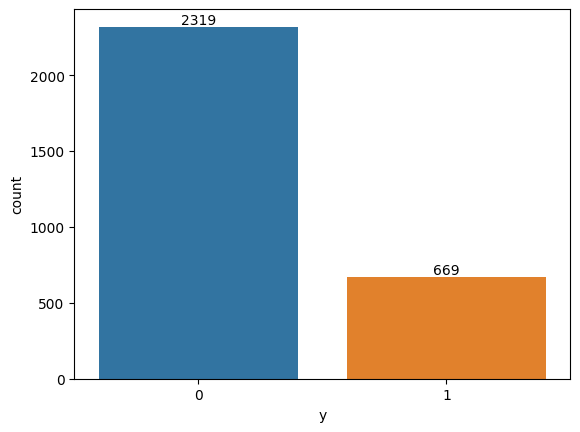

In [121]:
ax = sns.countplot(x=y['y'])
ax.bar_label(ax.containers[0])
ax.figure.savefig(
    ANALYSIS_DIR / 'images' / 'preprocess' / 'y_imbalance.pdf',
    dpi=300,
    bbox_inches='tight'
)

# Oversampling of minority class

In [25]:
X_train_resampled, y_resampled = SMOTE().fit_resample(X_train, y)

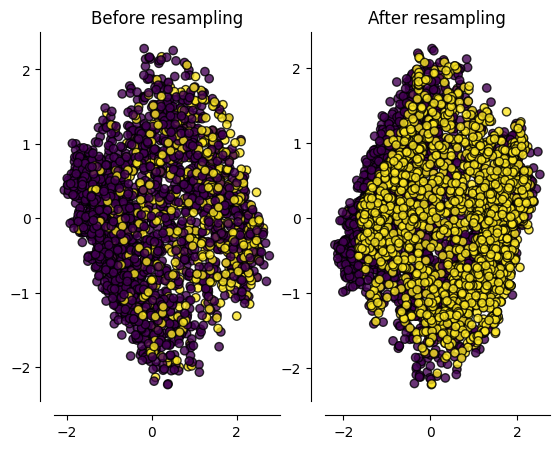

In [122]:
fig = plot_resampling(X_train, y, SMOTE())
fig.figure.savefig(
    ANALYSIS_DIR / 'images' / 'preprocess' / 'y_resampled.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Save datasets

In [ ]:
X_train.to_parquet(STAGE_DIR / 'preprocess' / 'X_train.parquet')
X_test.to_parquet(STAGE_DIR / 'preprocess' / 'X_test.parquet')
y.to_parquet(STAGE_DIR / 'preprocess' / 'y.parquet')

In [64]:
X_train_resampled.to_parquet(STAGE_DIR / 'preprocess' / 'X_train_resampled.parquet')
y_resampled.to_parquet(STAGE_DIR / 'preprocess' / 'y_resampled.parquet')